In [1]:
pip install yfinance


Note: you may need to restart the kernel to use updated packages.


In [2]:
# import the libraries
 
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint   # use this library to find this out the p_value
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime

def downloadStockData(tickers,start,end):
    """
        This function downloads the Close price of the stock and creates a dataframe from it
        Params:
            tickers : a list of ticker of various stocks
            start   : it is the start date of the data to be downloaded. It is a datetime in datetime format.
            end     : it is the end date of the data to be downloaded. It is a datetime in datetime format.

        Return:
            A dataframe with all the close for of each stock on each open market day
    """
    ticker_data = yf.download(tickers, start, end)['Close']
    return ticker_data

In [3]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def findCointegrationValue(data,p_value_threshold=0.05):
    n=data.shape[1]
    score_matrix=np.zeros((n,n))
    pvalue_matrix=np.zeros((n,n))
    keys=data.keys()
    pairs=[]
    for i in range(n):
      for j in range(i+1,n):
        s1=data[keys[i]]
        s2=data[keys[j]]
        result=coint(s1,s2)
        score=result[0]
        pvalue=result[1]
        score_matrix[i,j]=score
        pvalue_matrix[i,j]=pvalue
        if pvalue<0.05:
          pairs.append({keys[i],keys[j]})
        """here we are returning a cointegration test score matrix, a p-value matrix, and list of all pairs for which the p-value was less than the threshold"""
    return score_matrix,pvalue_matrix,pairs

In [4]:
def getBestKCointergratedStocks(data,k=10,p_value_threshold=0.05):
    n=data.shape[1]
    score_matrix=np.zeros((n,n))
    pvalue_matrix=np.zeros((n,n))
    keys=data.keys()
    pairs=[]
    for i in range(n):
      for j in range(i+1,n):
        s1=data[keys[i]]
        s2=data[keys[j]]
        result=coint(s1,s2)
        score=result[0]
        pvalue=result[1]
        score_matrix[i,j]=score
        pvalue_matrix[i,j]=pvalue
        if pvalue<0.05:
          pairs.append({keys[i],keys[j]})
    k=min(k,len(pairs))
    finalResult=heapq.nsmallest(k,pairs)
    return finalResult
     

In [5]:
def zscore(series):
    return (series-series.mean())/np.std(series)

def distanceBetweenStocks(data1,data2,window_size):
    return np.sum(zscore(data1)-zscore(data2))**2  

In [7]:
def getBestKLessDistanceStocks(data,k=10):
    n=data.shape(1)
    keys=data.keys()
    result=pd.DataFrame()
    for i in range(n):
      distances=[]
      for j in range(i+1,n):
        distance=distanceBetweenStocks(data[keys[i]],data[keys[j]])
        distances.append(distance,keys[i],keys[j])
      df=pd.DataFrame(distances,columns=['distance','X','Y'])
      if(len(result)<k):result.append(df[df.distance==min(df.distance)])
    return result



In [8]:
tickers = ['HD', 'DIS','MSFT', 'BA', 'MMM', 'PFE', 'NKE', 'JNJ', 'MCD', 'INTC', 'XOM', 'GS', 'JPM', 'AXP', 'V', 'IBM', 'UNH', 'PG', 'GE', 'KO', 'CSCO', 'CVX', 'CAT', 'MRK', 'WMT', 'VZ', 'RTX', 'TRV', 'AAPL', 'ADBE', 'EBAY', 'QCOM', 'HPQ', 'JNPR', 'AMD']
start = datetime.datetime(2011,1,1)
end = datetime.datetime(2013,1,1)
data = downloadStockData(tickers,start,end)

[*********************100%***********************]  35 of 35 completed


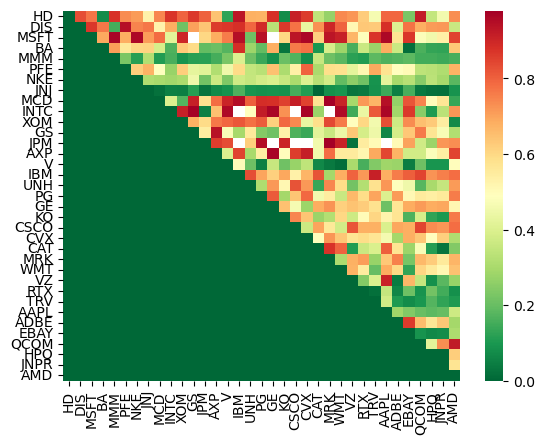

[{'KO', 'AXP'}, {'UNH', 'AXP'}, {'CVX', 'DIS'}, {'CVX', 'GE'}, {'CVX', 'HD'}, {'CVX', 'MRK'}, {'CVX', 'PFE'}, {'CVX', 'PG'}, {'CVX', 'TRV'}, {'CVX', 'V'}, {'CVX', 'VZ'}, {'CVX', 'WMT'}, {'HD', 'PFE'}, {'JNPR', 'IBM'}, {'MSFT', 'IBM'}, {'NKE', 'IBM'}, {'UNH', 'IBM'}, {'WMT', 'MRK'}, {'PFE', 'TRV'}, {'PG', 'QCOM'}, {'WMT', 'VZ'}]


In [9]:
score_matrix, pvalue_matrix, pairs = findCointegrationValue(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalue_matrix,xticklabels=tickers, 
                yticklabels=tickers,cmap='RdYlGn_r' 
                ,mask=(pvalue_matrix >= 0.98)
               )
plt.show()
print(pairs)

LET'S TAKE TWO COINTEGRATED STOCKS ('ADBE', 'MSFT').

0.8997642879128611


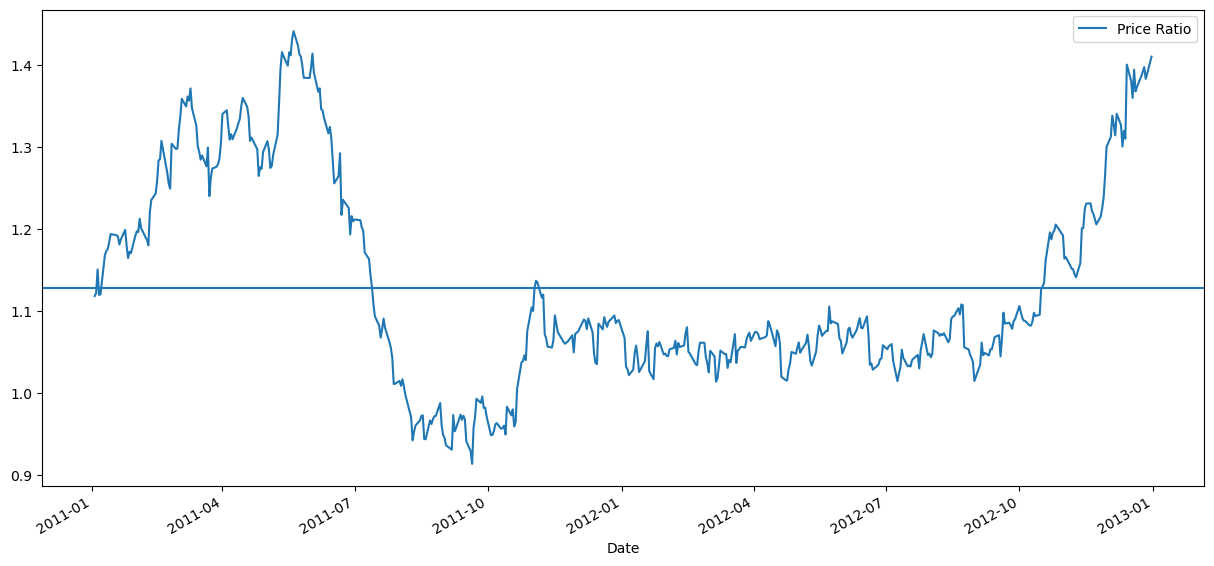

In [11]:
S1 = data['ADBE']
S2 = data['MSFT']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()
     

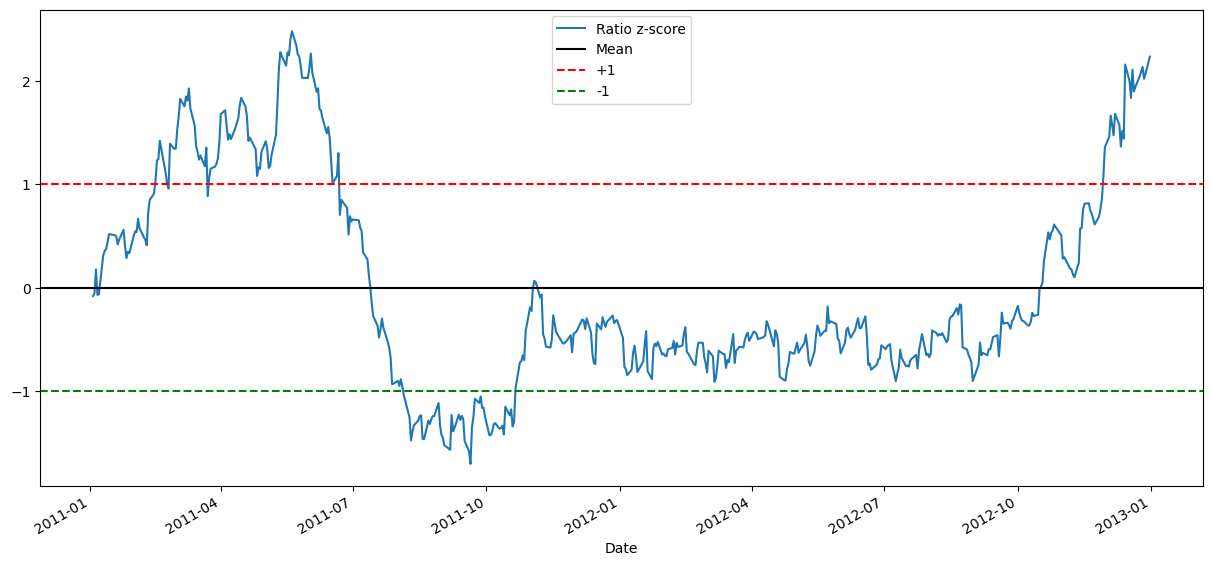

In [12]:
def zscore(series):
    return (series-series.mean())/np.std(series)

zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()


In [13]:
ratios = data['ADBE'] / data['MSFT']
print(len(ratios))
train = ratios[:1762]
test = ratios[1762:]

502


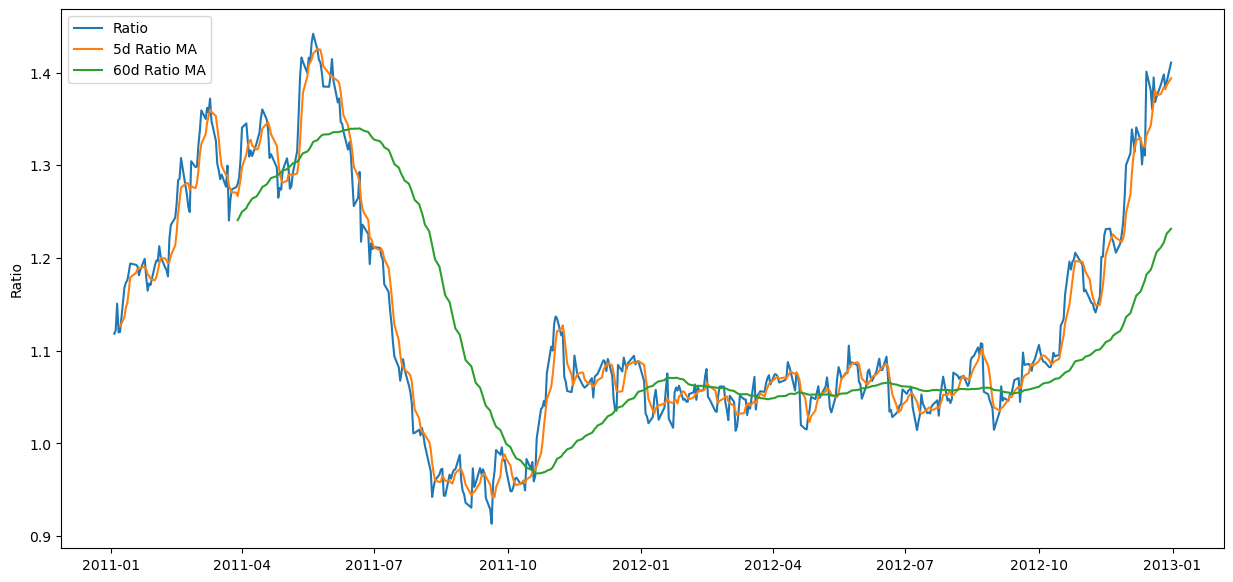

In [14]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()


We can use the moving averages to compute the z-score of the ratio at each given time. This will tell us how extreme the ratio is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.


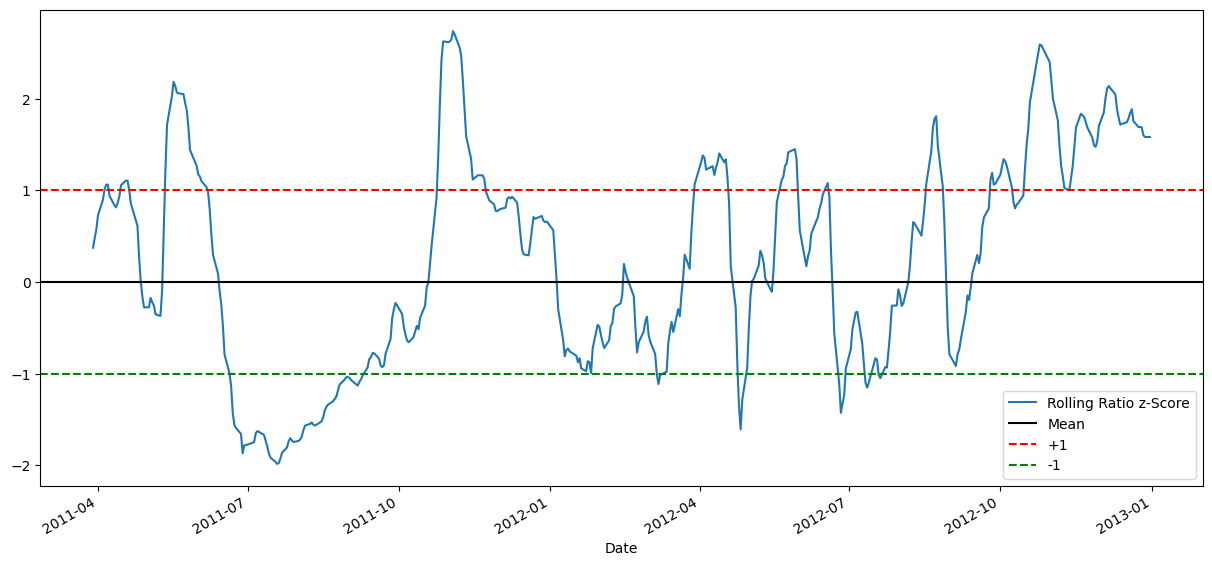

In [15]:
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

zscore_60_5=(ratios_mavg5-ratios_mavg60)/std_60
zscore_60_5.name='z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0,color='black')
plt.axhline(1.0,color='red',linestyle='--')
plt.axhline(-1.0,color='green',linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()
     

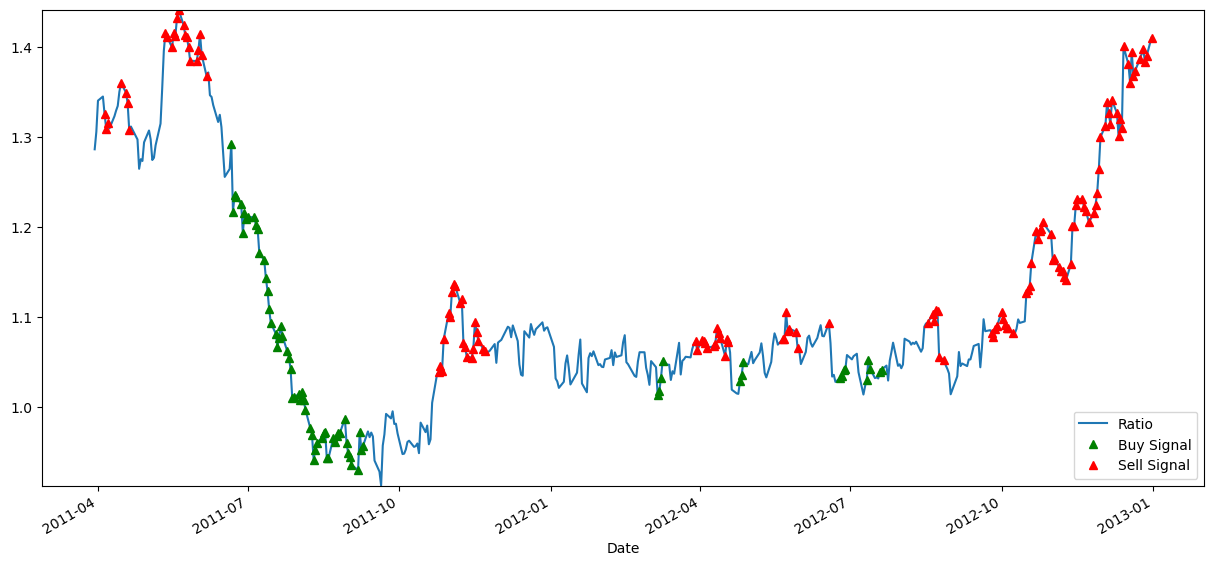

In [16]:
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like.

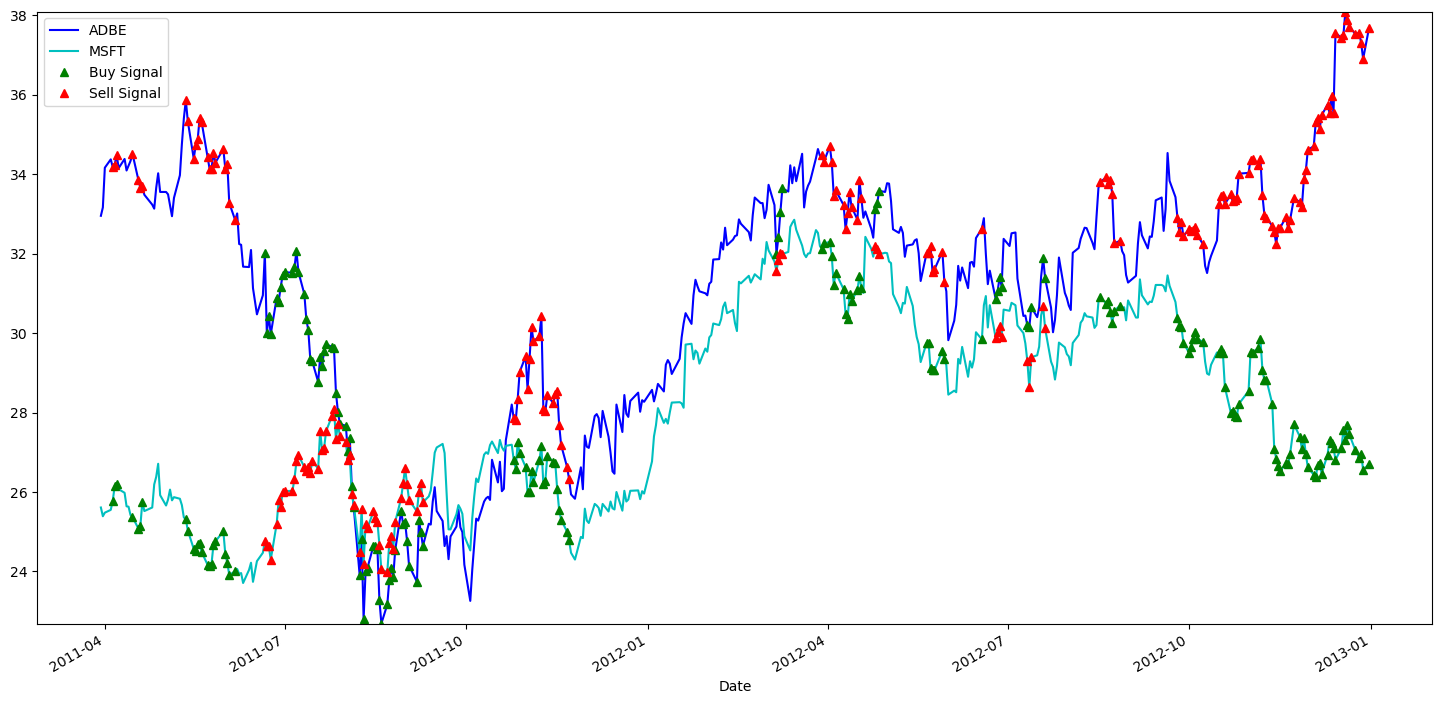

In [17]:
plt.figure(figsize=(18,9))
S1 = data['ADBE'].iloc[:1762]
S2 = data['MSFT'].iloc[:1762]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['ADBE','MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

Notice how we sometimes make money on the short leg and sometimes on the long leg, and sometimes both.

Let’s see what kind of profits this signal can generate. We write a simple backtester which buys 1 ratio (buy 1 ADBE stock and sell ratio x MSFT stock) when ratio is low, sell 1 ratio (sell 1 ADBE stock and buy ratio x MSFT stock) when it’s high and calculate PnL of these trades.



In [18]:
def trade(S1, S2, window1, window2):
    if (window1==0) or (window2==0):
        return 0
    ratios=S1/S2
    ma1=ratios.rolling(window=window1,center=False).mean()
    ma2=ratios.rolling(window=window2,center=False).mean()
    std=ratios.rolling(window=window2,center=False).std()
    zscore=(ma1-ma2)/std
    money=0
    countS1=0
    countS2=0
    for i in range(len(ratios)):
        if zscore[i] > 1:
            money+=S1[i]-S2[i]*ratios[i]
            countS1-=1
            countS2+=ratios[i]
        elif zscore[i]<-1:
            money-=S1[i]-S2[i]*ratios[i]
            countS1+=1
            countS2-=ratios[i]
        elif abs(zscore[i])<0.5:
            money+=countS1*S1[i]+S2[i]*countS2
            countS1=0
            countS2=0
    return money


trade(data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762], 5, 60)

29.914465510991274